In [1]:
import io
from collections import defaultdict, namedtuple, Counter

import unidecode

import numpy as np
from scipy.special import logsumexp, digamma

# import kaldi.fstext as fst
import openfst_python as fst
import sentencepiece as spm

from fst_sp import *

In [2]:
# TEXT = open('botchan.txt').read()

TEXT='abababaabb cacacacacacacaca acacacacacac ca caca cacaca ac acac acacac abcabcabcabcabcab'
TEXT = unidecode.unidecode(TEXT.lower())  #.replace(' ', '')
SENTENCES_BY_SPACE = [Sentence(text, count) for text, count in Counter(TEXT.split()).items()]
SENTENCES = [Sentence(line.strip(), 1) for line in TEXT.split('\n') if line.strip()]
TEXT = '\n'.join([s[0] for s in SENTENCES])

In [6]:
# Get the reference sentencpieces
model=io.BytesIO()
spm.SentencePieceTrainer.train(
    sentence_iterator=io.BytesIO(TEXT.encode()),
    model_writer=model,
    vocab_size=8, 
    shrinking_factor=0.85,
    num_sub_iterations=10
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 8
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.85
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 10
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
tr

In [7]:
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
FINAL_PIECES = list(extract_pieces(sp))
print(f"Tot unigram prob: {np.exp(logsumexp([piece.log_freq for piece in FINAL_PIECES if piece.log_freq != 0.0]))}")
FINAL_PIECES[:100]

Tot unigram prob: 0.8163016306690613


[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.4352858066558838),
 SentencePiece(index=4, symbol='ab', log_freq=-2.0434062480926514),
 SentencePiece(index=5, symbol='▁', log_freq=-4.326545715332031),
 SentencePiece(index=6, symbol='c', log_freq=-4.326645374298096),
 SentencePiece(index=7, symbol='a', log_freq=-4.326745510101318)]

In [8]:
# Get the initial vocab

model=io.BytesIO()
spm.SentencePieceTrainer.train(
    sentence_iterator=io.BytesIO(TEXT.encode()),
    model_writer=model,
    vocab_size=10,
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 10
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
tr

In [9]:
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
INITIAL_PIECES = list(extract_pieces(sp))
print(f"Tot unigram prob: {np.exp(logsumexp([piece.log_freq for piece in INITIAL_PIECES if piece.log_freq != 0.0]))}")
INITIAL_PIECES[:100]

Tot unigram prob: 0.8261814959746875


[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.5813193321228027),
 SentencePiece(index=4, symbol='ab', log_freq=-1.9380321502685547),
 SentencePiece(index=5, symbol='▁acacac', log_freq=-3.227902412414551),
 SentencePiece(index=6, symbol='▁cacaca', log_freq=-3.227902412414551),
 SentencePiece(index=7, symbol='▁', log_freq=-4.227703094482422),
 SentencePiece(index=8, symbol='c', log_freq=-4.227802753448486),
 SentencePiece(index=9, symbol='a', log_freq=-4.227902889251709)]

In [10]:
T = SentencePieceTrainer(INITIAL_PIECES)

In [11]:
# T.get_sp_to_char(INITIAL_PIECES)

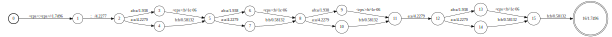

In [12]:
# sentence = 'abc a'
sentence = SENTENCES_BY_SPACE[0][0]
lattice = T.get_lattice(sentence, T.get_sp_to_char(INITIAL_PIECES))
lattice

In [13]:
T.viterbi(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)

[ViterbiPath(path=[7, 4, 4, 4, 9, 4, 3], prob=0.8022437625242183),
 ViterbiPath(path=[7, 9, 3, 4, 4, 9, 4, 3], prob=0.0454322711574762)]

In [14]:
T.compute_piece_counts(sentence, T.get_sp_to_char(INITIAL_PIECES, 'log'))

PieceCounts(Z=16.5687141, counts=defaultdict(<class 'float'>, {7: 1.0000004600001082, 4: 3.7856164250649207, 9: 1.2143862827175234, 3: 1.2143855206948173}))

In [15]:
# TODO: verify why EM returns different results, when our Viterbi seems to be OK
assert len(sp.tokenize(SENTENCES[0][0])) == len(T.viterbi(SENTENCES[0][0], T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])
print(list(zip(sp.tokenize(SENTENCES[0][0]), T.viterbi(SENTENCES[0][0], T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])))

[(7, 7), (4, 4), (4, 4), (4, 4), (9, 9), (4, 4), (3, 3), (6, 6), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (5, 5), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (7, 7), (8, 8), (9, 9), (7, 7), (8, 8), (9, 9), (8, 8), (9, 9), (6, 6), (7, 7), (9, 9), (8, 8), (7, 7), (9, 9), (8, 8), (9, 9), (8, 8), (5, 5), (7, 7), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4)]


In [16]:
for S, _ in SENTENCES_BY_SPACE[:10]:
    assert len(sp.tokenize(S)) == len(T.viterbi(S, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])
    print(list(zip(sp.tokenize(S), T.viterbi(S, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])))

[(7, 7), (4, 4), (4, 4), (4, 4), (9, 9), (4, 4), (3, 3)]
[(6, 6), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9)]
[(5, 5), (9, 9), (8, 8), (9, 9), (8, 8), (9, 9), (8, 8)]
[(7, 7), (8, 8), (9, 9)]
[(7, 7), (8, 8), (9, 9), (8, 8), (9, 9)]
[(6, 6)]
[(7, 7), (9, 9), (8, 8)]
[(7, 7), (9, 9), (8, 8), (9, 9), (8, 8)]
[(5, 5)]
[(7, 7), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4), (8, 8), (4, 4)]


In [18]:
# Sentencepiece training
pieces = INITIAL_PIECES
sentences = SENTENCES_BY_SPACE

DESIRED_PIECES = 8
PRUNE_FRAC = 0.85
NUM_SUBITER = 10

while True:
    # EM Step
    for sub_iter in range(NUM_SUBITER):  # num_sub_iterations
        e_ret = T.EStep(pieces, sentences)
        pieces = T.MStep(pieces, e_ret.counts)
        print(f"EM sub_iter={sub_iter} size={len(pieces)} tot_piece_prob={np.exp(logsumexp([piece.log_freq for piece in pieces]))} "
              f"obj={e_ret.objective} num_tokens={e_ret.n_tokens} num_tokens/piece={e_ret.n_tokens / len(pieces)}" )
    
    if len(pieces) <= DESIRED_PIECES:
        break

    pieces = T.prune_pieces(pieces, sentences, DESIRED_PIECES, PRUNE_FRAC)
    if len(pieces) <= DESIRED_PIECES:
        break
        
# TODO: add finalization

EM sub_iter=0 size=7 tot_piece_prob=0.9473977784125238 obj=20.143541617999997 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=1 size=7 tot_piece_prob=0.9473907525270666 obj=9.007325607000002 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=2 size=7 tot_piece_prob=0.9473785419701616 obj=9.012519208 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=3 size=7 tot_piece_prob=0.9473760075023951 obj=9.015252964999998 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=4 size=7 tot_piece_prob=0.9473754203870208 obj=9.016210136 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=5 size=7 tot_piece_prob=0.9473752001825962 obj=9.016507768 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=6 size=7 tot_piece_prob=0.9473751183357986 obj=9.016600045 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=7 size=7 tot_piece_prob=0.9473751554085614 obj=9.016627024000002 num_tokens=55 num_tokens/piece=7.857142857142857
EM sub_iter=8 s

In [19]:
FINAL_PIECES

[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.4352858066558838),
 SentencePiece(index=4, symbol='ab', log_freq=-2.0434062480926514),
 SentencePiece(index=5, symbol='▁', log_freq=-4.326545715332031),
 SentencePiece(index=6, symbol='c', log_freq=-4.326645374298096),
 SentencePiece(index=7, symbol='a', log_freq=-4.326745510101318)]

In [20]:
pieces

[SentencePiece(index=3, symbol='b', log_freq=-4.271026063923138),
 SentencePiece(index=4, symbol='ab', log_freq=-1.7747283462605172),
 SentencePiece(index=5, symbol='▁acacac', log_freq=-3.5841411201032565),
 SentencePiece(index=6, symbol='▁cacaca', log_freq=-3.5841405392594385),
 SentencePiece(index=7, symbol='▁', log_freq=-2.2952878115703212),
 SentencePiece(index=8, symbol='c', log_freq=-1.0837235132295215),
 SentencePiece(index=9, symbol='a', log_freq=-1.3119612453736766)]